In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Compute an approximate Network Community Profile (NCP) using Metis + MQI.

Input:  edge list file (u v) with 0- or 1-based ids (we'll relabel to 0..n-1)
Output: ncp.csv (k, best_phi) and ncp.png figure

Dependencies: numpy, scipy, networkx, matplotlib, pymetis, localgraphclustering
"""
import sys
sys.path.append("../")
sys.path.append("../localgraphclustering/cpp")



import argparse, csv, random, math, sys
from collections import defaultdict

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import pymetis  # Metis 5.1 wrapper: part_graph(adjacency=..., nparts=2)
# LocalGraphClustering: GraphLocal + MQI (C++ backend)
from localgraphclustering.GraphLocal import GraphLocal
from localgraphclustering.MQI_weighted import MQI_weighted  # returns (set_indices, conductance)
from localgraphclustering.cpp.MQI_cpp import MQI_cpp  # returns (set_indices, conductance)

Sample 1/50: cluster size=101, phi=0.2387
Sample 2/50: cluster size=2, phi=0.6667
Sample 3/50: cluster size=4, phi=0.5714
Sample 4/50: cluster size=7, phi=0.3538
Sample 5/50: cluster size=11, phi=0.4503
Sample 6/50: cluster size=5, phi=0.3571
Sample 7/50: cluster size=1059, phi=0.0308
Sample 8/50: cluster size=20, phi=0.2381
Sample 9/50: cluster size=3, phi=0.4000
Sample 10/50: cluster size=289, phi=0.1177
Sample 11/50: cluster size=8, phi=0.6336
Sample 12/50: cluster size=510, phi=0.0724
Sample 13/50: cluster size=196, phi=0.0403
Sample 14/50: cluster size=55, phi=0.0505
Sample 15/50: cluster size=5, phi=0.5000
Sample 16/50: cluster size=37, phi=0.0901
Sample 17/50: cluster size=54, phi=0.1135
Sample 18/50: cluster size=2, phi=0.6000
Sample 19/50: cluster size=2, phi=0.6000
Sample 20/50: cluster size=14, phi=0.1429
Sample 21/50: cluster size=198, phi=0.0357
Sample 22/50: cluster size=9, phi=0.3663
Sample 23/50: cluster size=6, phi=0.4146
Sample 24/50: cluster size=3, phi=0.6667
Sample

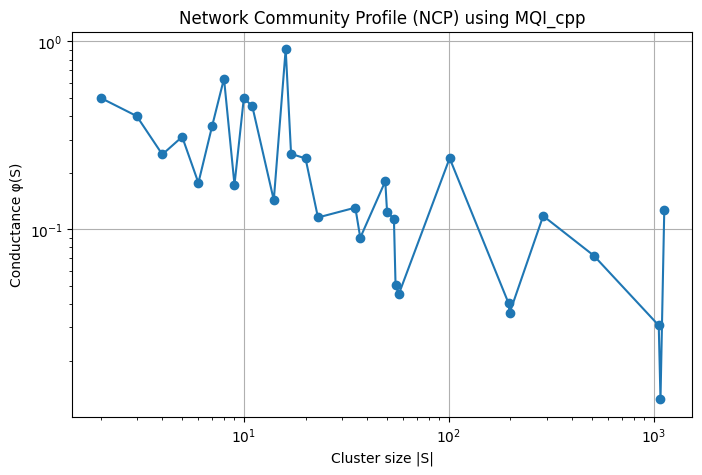

In [ ]:
# import networkx as nx
# import numpy as np
# import random
# import matplotlib.pyplot as plt
# # from MQI_cpp import MQI_cpp  # or MQI_weighted_cpp if you have weighted graph

# # -----------------------------
# # Helper functions
# # -----------------------------

# def nx_to_csr(G):
#     """
#     Convert NetworkX graph to CSR arrays (ai, aj) for MQI_cpp.
#     ai: index pointer
#     aj: adjacency list flattened
#     """
#     n = G.number_of_nodes()
#     nodes = list(G.nodes())
#     node_map = {node: i for i, node in enumerate(nodes)}
    
#     ai = [0]
#     aj = []
#     for node in nodes:
#         neighbors = [node_map[nb] for nb in G.neighbors(node)]
#         aj.extend(neighbors)
#         ai.append(len(aj))
#     ai = np.array(ai, dtype=np.int64)
#     aj = np.array(aj, dtype=np.int64)
#     return n, ai, aj, node_map


# def compute_phi(G, cluster_nodes):
#     """Compute conductance φ(S) of cluster_nodes"""
#     cluster_set = set(cluster_nodes)
#     if len(cluster_set) == 0 or len(cluster_set) == G.number_of_nodes():
#         return 0.0  # or np.nan if you want to ignore it

#     cut_edges = 0
#     vol_S = sum(G.degree(n) for n in cluster_set)
#     vol_bar_S = sum(G.degree(n) for n in G.nodes() if n not in cluster_set)

#     for u in cluster_set:
#         for v in G.neighbors(u):
#             if v not in cluster_set:
#                 cut_edges += 1

#     # Avoid division by zero just in case
#     if vol_S == 0 or vol_bar_S == 0:
#         return 0.0

#     return cut_edges / min(vol_S, vol_bar_S)


# # -----------------------------
# # NCP computation using MQI_cpp
# # -----------------------------

# def ncp_mqi_python(G, num_samples=50, min_seed=10, max_seed=200):
#     best_phi = {}

#     # Convert graph to CSR
#     n, ai, aj, node_map = nx_to_csr(G)
#     nodes = list(G.nodes())

#     for i in range(num_samples):
#         k = random.randint(min_seed, max_seed)
#         seed_nodes = random.sample(nodes, k)
#         R = [node_map[node] for node in seed_nodes]  # map to CSR indices
#         nR = len(R)

#         # Call MQI_cpp
#         actual_length, actual_set = MQI_cpp(n, ai, aj, nR, R)

#         # Map back to original node IDs
#         inv_node_map = {v: k for k, v in node_map.items()}
#         cluster_nodes = [inv_node_map[i] for i in actual_set]

#         # Compute conductance
#         phi = compute_phi(G, cluster_nodes)
#         size = len(cluster_nodes)
#         if size not in best_phi or phi < best_phi[size]:
#             best_phi[size] = phi

#         print(f"Sample {i+1}/{num_samples}: cluster size={size}, phi={phi:.4f}")

#     return best_phi

# # -----------------------------
# # Example usage
# # -----------------------------

# # Load a graph
# INPUT_EDGE_LIST = "/home/ofrie.r/LocalGraphClustering/datasets/facebook/facebook_combined.txt"
# G = nx.read_edgelist(INPUT_EDGE_LIST, nodetype=int)
# # Compute NCP
# best_phi = ncp_mqi_python(G, num_samples=50, min_seed=10, max_seed=4000)

# # Plot NCP
# sizes = sorted(best_phi.keys())
# phis = [best_phi[s] for s in sizes]

# plt.figure(figsize=(8,5))
# plt.plot(sizes, phis, marker='o')
# plt.xlabel("Cluster size |S|")
# plt.ylabel("Conductance φ(S)")
# plt.xscale('log')   # optional: log scale often used for NCPs
# plt.yscale('log')   # optional
# plt.title("Network Community Profile (NCP) using MQI_cpp")
# plt.grid(True)
# plt.show()


In [ ]:
# import networkx as nx
# import random
# import subprocess
# import tempfile
# import os
# import matplotlib.pyplot as plt

# # -----------------------------
# # Helper functions
# # -----------------------------

# def compute_phi(G, S):
#     """Compute conductance φ(S) of a cluster S"""
#     cut_edges = 0
#     vol_S = sum(G.degree(n) for n in S)
#     vol_bar_S = sum(G.degree(n) for n in G.nodes() if n not in S)

#     for u in S:
#         for v in G.neighbors(u):
#             if v not in S:
#                 cut_edges += 1
#     return cut_edges / min(vol_S, vol_bar_S)

# def save_seed_set(seed_set, filepath):
#     """Save seed set to file for MQI"""
#     with open(filepath, 'w') as f:
#         for node in seed_set:
#             f.write(f"{node}\n")

# def save_edgelist(G, filepath):
#     """Save graph edgelist for MQI"""
#     nx.write_edgelist(G, filepath, data=False)

# def run_mqi(graph_file, seed_file, output_file, mqi_binary="./MQI"):
#     """Call the MQI binary on the graph + seed set"""
#     cmd = f"{mqi_binary} {graph_file} {seed_file} {output_file}"
#     subprocess.run(cmd, shell=True, check=True)
#     # Read refined cluster
#     with open(output_file, 'r') as f:
#         cluster_nodes = set(int(line.strip()) for line in f)
#     return cluster_nodes

# # -----------------------------
# # NCP computation
# # -----------------------------

# def ncp_mqi(G, num_samples=50, min_seed=10, max_seed=200, mqi_binary="./MQI"):
#     best_phi = {}
#     nodes = list(G.nodes())

#     with tempfile.TemporaryDirectory() as tmpdir:
#         # Save the graph once
#         graph_file = os.path.join(tmpdir, "graph.txt")
#         save_edgelist(G, graph_file)

#         for i in range(num_samples):
#             # Random seed size
#             k = random.randint(min_seed, max_seed)
#             seed_set = set(random.sample(nodes, k))
#             seed_file = os.path.join(tmpdir, f"seed_{i}.txt")
#             output_file = os.path.join(tmpdir, f"cluster_{i}.txt")
#             save_seed_set(seed_set, seed_file)

#             # Call MQI to refine cluster
#             cluster = run_mqi(graph_file, seed_file, output_file, mqi_binary=mqi_binary)

#             phi = compute_phi(G, cluster)
#             size = len(cluster)
#             if size not in best_phi or phi < best_phi[size]:
#                 best_phi[size] = phi

#             print(f"Sample {i+1}/{num_samples}: cluster size={size}, phi={phi:.4f}")

#     return best_phi


In [ ]:
# # INPUT_EDGE_LIST = "/home/ofrie.r/LocalGraphClustering/datasets/facebook/facebook_combined.txt"
    
# G = nx.read_edgelist(INPUT_EDGE_LIST, nodetype=int)
# print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# # Compute NCP
# best_phi = ncp_mqi(G, num_samples=50, min_seed=10, max_seed=200, mqi_binary="./MQI")

# # Plot
# sizes = sorted(best_phi.keys())
# phis = [best_phi[s] for s in sizes]

# plt.figure(figsize=(8,5))
# plt.plot(sizes, phis, marker='o')
# plt.xlabel("Cluster size |S|")
# plt.ylabel("Conductance φ(S)")
# plt.title("Network Community Profile (NCP) using METIS+MQI")
# plt.grid(True)
# plt.show()



In [ ]:
best_phi

In [ ]:
# import csv
# import random
# import networkx as nx

# # -------------------------------------------------------------
# # Params (EDIT THESE)
# # -------------------------------------------------------------
# INPUT_EDGE_LIST = "/home/ofrie.r/LocalGraphClustering/datasets/facebook/facebook_combined.txt"
# SAMPLES = 100
# MIN_SEED = 30
# MAX_SEED = 200
# OUTPUT_CSV = "sampled_sets.csv"
# sep = None                       # e.g. ',' or '\t' or None for whitespace




# # -------------------------------------------------------------
# # Helper: conductance calculation
# # -------------------------------------------------------------
# def conductance(G, S):
#     S = set(S)
#     if len(S) == 0 or len(S) == len(G):
#         return 1.0

#     vol_S = sum(G.degree(u) for u in S)
#     vol_notS = sum(G.degree(u) for u in G.nodes if u not in S)

#     cut = 0
#     for u in S:
#         for v in G.neighbors(u):
#             if v not in S:
#                 cut += 1

#     denom = min(vol_S, vol_notS)
#     if denom == 0:
#         return 1.0
#     return cut / denom


# def local_expand_conductance(G, S):
#     """
#     Very simple greedy improvement: repeatedly try adding/removing a node
#     if it improves conductance. Terminates when no change improves phi.
#     """

#     S = set(S)
#     improved = True

#     while improved:
#         improved = False
#         current_phi = conductance(G, S)

#         # Try adding neighbors
#         boundary = set()
#         for u in S:
#             boundary.update(G.neighbors(u))
#         boundary -= S

#         for v in list(boundary):
#             newS = S | {v}
#             phi2 = conductance(G, newS)
#             if phi2 < current_phi:
#                 S = newS
#                 improved = True
#                 break

#         if improved:
#             continue

#         # Try removing internal vertices
#         for v in list(S):
#             if len(S) <= 1:
#                 break
#             newS = S - {v}
#             phi2 = conductance(G, newS)
#             if phi2 < current_phi:
#                 S = newS
#                 improved = True
#                 break

#     return S, conductance(G, S)


# # -------------------------------------------------------------
# # Wrapper: try METIS + MQI if possible, else fallback
# # -------------------------------------------------------------
# def refine_with_metis_mqi(G, S):
#     # We need these only if METIS/MQI is installed — otherwise fallback
#     try:
#         from networkit.community import PLM
#         from networkit.graph import Graph as NkGraph
#         import networkit
#         mqi_available = True
#     except ImportError:
#         mqi_available = False

#     # If too small or METIS is unavailable → fallback
#     if len(S) < 50 or not mqi_available:
#         return local_expand_conductance(G, S)

#     # ---- Convert to NetworKit graph ----
#     mapping = {u: i for i, u in enumerate(G.nodes())}
#     revmap = {i: u for u, i in mapping.items()}
#     n = len(mapping)
#     nkG = networkit.graph.Graph(n, weighted=False, directed=False)

#     for u, v in G.edges():
#         nkG.addEdge(mapping[u], mapping[v])

#     # ---- Use PLM for 2-way partition ----
#     plm = PLM(nkG)
#     parts = plm.run().getPartition()

#     S_mapped = {mapping[u] for u in S}
#     # Find majority side of S
#     count0 = sum(parts[u] == 0 for u in S_mapped)
#     count1 = len(S_mapped) - count0
#     target_side = 0 if count0 >= count1 else 1
#     approx = {revmap[i] for i in range(n) if parts[i] == target_side}

#     # ---- MQI refinement (fallback to local method if MQI fails) ----
#     try:
#         from networkit.community import MQI
#         seed_side = [i for i in approx]
#         mqi = MQI(nkG, seed_side)
#         final_side = mqi.run()
#         final = {revmap[i] for i in final_side}
#         return final, conductance(G, final)
#     except Exception:
#         return local_expand_conductance(G, S)


# # -------------------------------------------------------------
# # Main
# # -------------------------------------------------------------
# print("Loading graph...")
# G = nx.read_edgelist(INPUT_EDGE_LIST, nodetype=int)
# G = nx.Graph(G)  # ensure simple undirected
# G.remove_edges_from(nx.selfloop_edges(G))
# gl = GraphLocal(INPUT_EDGE_LIST, 'edgelist', sep if sep is not None else ' ')



# nodes = list(G.nodes())

# rows = []

# print("Sampling communities...")
# for i in range(SAMPLES):
#     # Draw a seed size in your desired restricted range
#     k = random.randint(MIN_SEED, MAX_SEED)
#     S0 = set(random.sample(nodes, k))

#     # Refine (using METIS+MQI only if appropriate)
#     S_final, phi = refine_with_metis_mqi(G, S0)
#     # S_final, phi = MQI_weighted(gl, S0)


#     rows.append([i, len(S0), len(S_final), phi])

#     if i % 10 == 0:
#         print(f"{i}/{SAMPLES} – seed {len(S0)} → final {len(S_final)}, phi={phi:.4f}")

# # -------------------------------------------------------------
# # Write CSV
# # -------------------------------------------------------------
# print("Writing CSV...")
# with open(OUTPUT_CSV, "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerow(["sample_id", "seed_size", "final_size", "phi"])
#     writer.writerows(rows)

# print("Done! Saved to:", OUTPUT_CSV)


In [ ]:
# import matplotlib.pyplot as plt
# import csv

# # --- Read results from CSV ---
# sizes = []
# phis = []

# with open(OUTPUT_CSV, "r") as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         sizes.append(int(row["final_size"]))
#         phis.append(float(row["phi"]))

# # --- Plot NCP ---
# plt.figure(figsize=(8,5))
# plt.scatter(sizes, phis, color='blue', alpha=0.6, label='Sampled communities')
# plt.xlabel("Community size |S|")
# plt.ylabel("Conductance φ(S)")
# plt.title("Network Community Profile (NCP)")
# plt.xscale('log')   # optional: log scale often used for NCPs
# plt.yscale('log')   # optional
# plt.grid(True, which="both", ls="--", lw=0.5)
# plt.legend()
# plt.show()


In [3]:


# ---------- helpers ----------

def load_graph_relabel_zero(edgelist_path, sep=None):
    """Load edge list -> undirected simple graph relabeled to 0..n-1."""
    G = nx.read_edgelist(edgelist_path, delimiter=sep, nodetype=str)
    G = nx.Graph(G)  # simple
    G.remove_edges_from(nx.selfloop_edges(G))
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping, copy=True)
    return G

def nx_to_pymetis_adjacency(G):
    """Return adjacency as a list-of-lists suitable for pymetis.part_graph."""
    n = G.number_of_nodes()
    adj = [[] for _ in range(n)]
    for u, v in G.edges():
        adj[u].append(v)
        adj[v].append(u)
    return adj

def metis_bisection(adj, perm=None):
    """Run a 2-part Metis partition; optionally permute node order for randomness."""
    if perm is None:
        perm = list(range(len(adj)))
    # Apply permutation to adjacency
    inv = [0]*len(perm)
    for i,p in enumerate(perm): inv[p] = i
    adj_perm = [[inv[v] for v in adj[perm[u]]] for u in range(len(adj))]
    _, parts = pymetis.part_graph(2, adjacency=adj_perm)
    # Unpermute labels
    unpermuted = [None]*len(parts)
    for i,p in enumerate(perm):
        unpermuted[p] = parts[i]
    return unpermuted

def small_side_from_parts(parts):
    """Return the index set of the smaller part."""
    idx0 = [i for i,p in enumerate(parts) if p == 0]
    idx1 = [i for i,p in enumerate(parts) if p == 1]
    return idx0 if len(idx0) <= len(idx1) else idx1

def ensure_connected_component(G, S):
    """Keep the largest connected component of S (MQI can be disconnected)."""
    if S is None or len(S) == 0:
        return []

    # Ensure S is iterable and hashable (e.g. convert numpy array to list)
    if not isinstance(S, (list, set)):
        try:
            S = list(S)
        except Exception:
            return []

    sub = G.subgraph(S)
    if sub.number_of_nodes() == 0:
        return []

    # Largest connected component
    comps = max(nx.connected_components(sub), key=len)
    return sorted(comps)


def compute_ncp_best_by_size(samples, n):
    # """
    # samples: iterable of (k, phi)
    # Returns best_phi[k] for k=1..n, where best_phi[k] = min phi observed with |S|=k
    # Then we lower-envelope fill: for increasing k, carry forward the running minimum.
    # """
    # best = {}
    # for k,phi in samples:
    #     if k <= 0 or k > n: 
    #         continue
    #     if k not in best or phi < best[k]:
    #         best[k] = phi
    # # running lower envelope
    # best_phi = [math.nan]*(n+1)
    # running = math.inf
    # for k in range(1, n+1):
    #     if k in best and best[k] < running:
    #         running = best[k]
    #     best_phi[k] = running if running < math.inf else math.nan
    # return best_phi
    # """
    # samples: iterable of (k, phi)
    # Returns best_phi[k] for k=1..n, where best_phi[k] = min phi observed with |S|=k
    # Does NOT enforce monotonicity; reflects actual observed data.
    # """
    # """
    # Returns a list of (k, phi) for all valid samples,
    # without any aggregation or monotonic adjustment.
    # """
    # return [(k, phi) for k, phi in samples if 1 <= k <= n]
    best_phi = [math.nan] * (n + 1)

    for k, phi in samples:
        if k <= n:
            if math.isnan(best_phi[k]) or phi < best_phi[k]:
                best_phi[k] = phi

    return best_phi


[i] Loading graph from /home/ofrie.r/LocalGraphClustering/datasets/facebook/facebook_combined.txt ...


[i] Graph: n=4039, m=88234


/home/ofrie.r/miniconda3/envs/lgc_env/lib/python3.11/site-packages/localgraphclustering/GraphLocal.py:198: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



[i] trial 200/2000, total unique sets: 963
[i] trial 400/2000, total unique sets: 1891
[i] trial 600/2000, total unique sets: 2806
[i] trial 800/2000, total unique sets: 3693
[i] trial 1000/2000, total unique sets: 4572
[i] trial 1200/2000, total unique sets: 5426
[i] trial 1400/2000, total unique sets: 6290
[i] trial 1600/2000, total unique sets: 7150
[i] trial 1800/2000, total unique sets: 7990
[i] trial 2000/2000, total unique sets: 8822
samples collected: 8822
min |S'|, max |S'|: 0 774
size distribution (top 10): [(2, 1893), (4, 1492), (3, 945), (5, 580), (543, 472), (341, 428), (6, 299), (206, 289), (7, 230), (544, 172)]
[i] Wrote ncp.csv
[i] Wrote ncp.png
[i] Wrote samples_diverse.csv


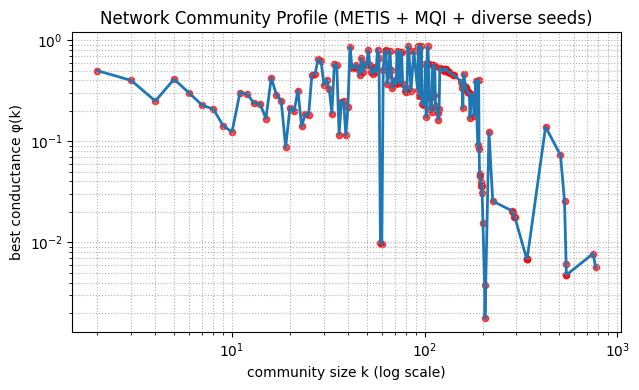

In [5]:
import networkx as nx
import random, csv, math
import matplotlib.pyplot as plt
from collections import Counter

# ---------- helper functions (assume defined) ----------
# load_graph_relabel_zero, nx_to_pymetis_adjacency,
# metis_bisection, small_side_from_parts, ensure_connected_component,
# compute_ncp_best_by_size, MQI_weighted

# ---------- new helper functions for diverse seeds ----------
def bfs_grow(adj, start, target_k):
    """Grow a connected cluster using BFS to a target size."""
    from collections import deque
    S = {start}
    q = deque([start])
    while q and len(S) < target_k:
        u = q.popleft()
        for v in adj[u]:
            if v not in S:
                S.add(v)
                q.append(v)
            if len(S) >= target_k:
                break
    return S

def random_walk_grow(adj, start, target_k, max_steps=1000):
    """Grow a cluster via random walk until target size."""
    S = {start}
    cur = start
    for _ in range(max_steps):
        neighs = adj[cur]
        if not neighs:
            break
        cur = random.choice(neighs)
        S.add(cur)
        if len(S) >= target_k:
            break
    return S

def deduplicate_set(S, seen_sets):
    """Check if S is new; returns True if added."""
    f = frozenset(S)
    if f in seen_sets:
        return False
    seen_sets.add(f)
    return True

# ---------- user parameters ----------
input_path = "/home/ofrie.r/LocalGraphClustering/datasets/facebook/facebook_combined.txt"
sep = None
trials = 2000       # total sampling attempts
seed = 13
keep_connected = False
out_csv = "ncp.csv"
out_png = "ncp.png"
samples_csv = "samples_diverse.csv"

# ---------- main pipeline ----------
rng = random.Random(seed)

print(f"[i] Loading graph from {input_path} ...")
G_nx = load_graph_relabel_zero(input_path, sep=sep)
n = G_nx.number_of_nodes()
m = G_nx.number_of_edges()
print(f"[i] Graph: n={n}, m={m}")

gl = GraphLocal(input_path, 'edgelist', sep if sep is not None else ' ')
adj = nx_to_pymetis_adjacency(G_nx)

samples = []
seen_sets = set()  # deduplication

# degree-based seeds for diversity
degrees = dict(G_nx.degree())
nodes_sorted_by_degree = sorted(degrees, key=degrees.get, reverse=True)
high_deg_nodes = nodes_sorted_by_degree[:50]
low_deg_nodes = nodes_sorted_by_degree[-50:]
all_nodes = list(G_nx.nodes())

# ---------- diversified sampling loop ----------
for t in range(trials):
    seed_nodes = []

    # 1) METIS small side (guarantees near-minimum φ)
    perm = list(range(n))
    rng.shuffle(perm)
    parts = metis_bisection(adj, perm=perm)
    S0 = small_side_from_parts(parts)
    if 0 < len(S0) < n:
        seed_nodes.append(S0)

    # 2) BFS / random-walk / degree seeds for extra diversity
    # a) BFS inside METIS small side
    if S0:
        for _ in range(1):
            start = rng.choice(list(S0))
            target_k = rng.randint(5, min(len(S0), 200))
            S_bfs = bfs_grow(adj, start, target_k)
            seed_nodes.append(S_bfs)

    # b) Random walk from random nodes
    for _ in range(1):
        start = rng.choice(all_nodes)
        target_k = rng.randint(5, 200)
        S_rw = random_walk_grow(adj, start, target_k)
        seed_nodes.append(S_rw)

    # c) High-degree / low-degree seeds
    for start in [rng.choice(high_deg_nodes), rng.choice(low_deg_nodes)]:
        target_k = rng.randint(5, 200)
        S_bfs = bfs_grow(adj, start, target_k)
        seed_nodes.append(S_bfs)

    # ---------- process candidate seeds ----------
    for S_candidate in seed_nodes:
        if not deduplicate_set(S_candidate, seen_sets):
            continue

        # refine with MQI
        improved_set, phi_val = MQI_weighted(gl, S_candidate)

        # optionally ensure connected component
        if keep_connected:
            improved_set = ensure_connected_component(G_nx, improved_set)
            if len(improved_set) == 0:
                continue
            phi_val = gl.compute_conductance(improved_set)

        samples.append((len(improved_set), float(phi_val)))

    # progress printing
    if (t + 1) % max(1, trials // 10) == 0:
        print(f"[i] trial {t+1}/{trials}, total unique sets: {len(samples)}")

# ---------- finalize NCP ----------
if not samples:
    raise RuntimeError("No samples collected; check your input graph.")

sizes = [s[0] for s in samples]
print("samples collected:", len(samples))
print("min |S'|, max |S'|:", min(sizes), max(sizes))
print("size distribution (top 10):", Counter(sizes).most_common(10))

# compute minimum φ per size (original NCP logic)
best_phi = compute_ncp_best_by_size(samples, n)

# save CSV
with open(out_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["k", "best_phi"])
    for k in range(1, len(best_phi)):
        w.writerow([k, best_phi[k]])
print(f"[i] Wrote {out_csv}")

# plot NCP
ks = [k for k in range(1, n + 1) if not math.isnan(best_phi[k])]
ys = [best_phi[k] for k in ks]
plt.figure(figsize=(6.5, 4.0))
plt.loglog(ks, ys, linewidth=2)
plt.scatter(ks, ys, color='red', s=20, alpha=0.7)
plt.xlabel("community size k (log scale)")
plt.ylabel("best conductance φ(k)")
plt.title("Network Community Profile (METIS + MQI + diverse seeds)")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.savefig(out_png, dpi=180)
print(f"[i] Wrote {out_png}")

# save raw samples
with open(samples_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["k", "phi"])
    for k, phi in samples:
        w.writerow([k, phi])
print(f"[i] Wrote {samples_csv}")


[i] Loading graph from /home/ofrie.r/LocalGraphClustering/datasets/facebook/facebook_combined.txt ...
[i] Graph: n=4039, m=88234


/home/ofrie.r/miniconda3/envs/lgc_env/lib/python3.11/site-packages/localgraphclustering/GraphLocal.py:198: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



[i] trial 500/5000: |S'|=206, phi=0.001762
[i] trial 1000/5000: |S'|=543, phi=0.006105
[i] trial 1500/5000: |S'|=341, phi=0.006860
[i] trial 2000/5000: |S'|=543, phi=0.006105
[i] trial 2500/5000: |S'|=206, phi=0.001762
[i] trial 3000/5000: |S'|=341, phi=0.006860
[i] trial 3500/5000: |S'|=543, phi=0.006105
[i] trial 4000/5000: |S'|=341, phi=0.006860
[i] trial 4500/5000: |S'|=206, phi=0.001762
[i] trial 5000/5000: |S'|=206, phi=0.001762
samples collected: 5000
min |S'|, max |S'|: 19 774
size distribution (top 10): [(543, 1556), (206, 1349), (341, 1152), (544, 427), (216, 131), (59, 82), (226, 78), (199, 38), (205, 30), (750, 18)]
[i] Wrote ncp.csv
[i] Wrote ncp.png


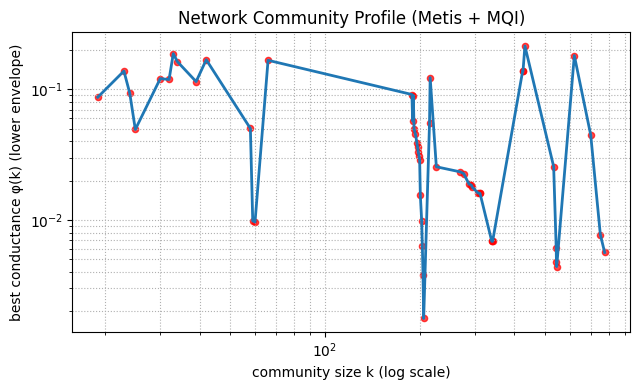

In [13]:
import networkx as nx
import random, csv, sys, math
import matplotlib.pyplot as plt

# assume these helper functions are defined elsewhere in your notebook:
# load_graph_relabel_zero, GraphLocal, nx_to_pymetis_adjacency,
# metis_bisection, small_side_from_parts, MQI_weighted,
# ensure_connected_component, compute_ncp_best_by_size

# ---------- user parameters ----------
input_path = "/home/ofrie.r/LocalGraphClustering/datasets/facebook/facebook_combined.txt"         # your edge list file
sep = None                       # e.g. ',' or '\t' or None for whitespace
trials = 5000
seed = 13
keep_connected = False
out_csv = "ncp.csv"
out_png = "ncp.png"
samples_csv = None               # or e.g. "samples.csv"

# ---------- main pipeline ----------

print(f"[i] Loading graph from {input_path} ...")
G_nx = load_graph_relabel_zero(input_path, sep=sep)
n = G_nx.number_of_nodes()
m = G_nx.number_of_edges()
print(f"[i] Graph: n={n}, m={m}")

gl = GraphLocal(input_path, 'edgelist', sep if sep is not None else ' ')
adj = nx_to_pymetis_adjacency(G_nx)

rng = random.Random()
samples = []

for t in range(trials):
    perm = list(range(n))
    rng.shuffle(perm)
    parts = metis_bisection(adj, perm=perm)
    S0 = small_side_from_parts(parts)
    if len(S0) == 0 or len(S0) == n:
        continue

    improved_set, phi_val = MQI_weighted(gl, S0)

    if keep_connected:
        improved_set = ensure_connected_component(G_nx, improved_set)
        if len(improved_set) == 0:
            continue
        phi_val = gl.compute_conductance(improved_set)

    samples.append((len(improved_set), float(phi_val)))

    if (t + 1) % max(1, trials // 10) == 0:
        print(f"[i] trial {t+1}/{trials}: |S'|={len(improved_set)}, phi={phi_val:.6f}")

if not samples:
    raise RuntimeError("No samples collected; check your input graph.")

###### DEBUG
sizes = [s[0] for s in samples]
print("samples collected:", len(samples))
print("min |S'|, max |S'|:", min(sizes), max(sizes))
from collections import Counter
print("size distribution (top 10):", Counter(sizes).most_common(10))
######
best_phi = compute_ncp_best_by_size(samples, n)

with open(out_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["k", "best_phi"])
    # for k in range(1, n + 1):
    #     w.writerow([k, best_phi[k]])
    for k in range(1, len(best_phi)):
        w.writerow([k, best_phi[k]])

print(f"[i] Wrote {out_csv}")

ks = [k for k in range(1, n + 1) if not math.isnan(best_phi[k])]
ys = [best_phi[k] for k in ks]
sample_ks = [s[0] for s in samples]
sample_phis = [s[1] for s in samples]
plt.figure(figsize=(6.5, 4.0))
plt.loglog(ks, ys, linewidth=2)
plt.scatter(ks, ys, color='red', s=20, alpha=0.7)
plt.xlabel("community size k (log scale)")
plt.ylabel("best conductance φ(k) (lower envelope)")
plt.title("Network Community Profile (Metis + MQI)")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.savefig(out_png, dpi=180)
print(f"[i] Wrote {out_png}")

with open("samples_raw.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(["k", "phi"])
    for k, p in samples:
        w.writerow([k, p])

if samples_csv:
    with open(samples_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["k", "phi"])
        for k, phi in samples:
            w.writerow([k, phi])
    print(f"[i] Wrote {samples_csv}")


In [14]:
print(len(set(samples)))


66


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load the main CSV files ---
df1 = pd.read_csv("ncp.csv")
df2 = pd.read_csv("samples_diverse.csv")

df1 = df1.sort_values("k")
df2 = df2.sort_values("k")

# --- Load the extra CSV with Phi_file, Phi_calc ---
df_extra = pd.read_csv("../target/verification_results.csv")
df_extra = df_extra.dropna()
df_extra = df_extra.sort_values("ClusterSize")

# --- Plot ---
plt.figure(figsize=(8,6))

# Original two datasets
plt.loglog(df1['k'], df1['best_phi'],
           marker='o', linestyle='-', label='pure metis_mqi',
           linewidth=4, markersize=4)

plt.loglog(df2['k'], df2['phi'],
           marker='s', linestyle='-', label='samples_diverse',
           linewidth=1, markersize=1)

# Extra CSV: Phi_file
plt.loglog(df_extra['ClusterSize'], df_extra['Phi_file'],
           marker='^', linestyle='--', label='verification: Phi_file',
           linewidth=1.5, markersize=3)

# Extra CSV: Phi_calc
plt.loglog(df_extra['ClusterSize'], df_extra['Phi_calc'],
           marker='v', linestyle='--', label='verification: Phi_calc',
           linewidth=1.5, markersize=3)

# Labels and formatting
plt.xlabel("k")
plt.ylabel("phi")
plt.title("Comparison of Three Datasets (log-log scale)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../target/verification_results.csv'

In [14]:
import pandas as pd

# Load the CSV files
ncp = pd.read_csv("ncp.csv")     # your first file
file2 = pd.read_csv("samples_diverse.csv") # the second file

# Merge on 'k' to align phi values
merged = pd.merge(ncp, file2, on='k', suffixes=('_ncp', '_file2'))

# Check if ncp phi <= file2 phi
merged['ncp_le_file2'] = merged['best_phi'] <= merged['phi']

# Optional: show results
print(merged[['k', 'best_phi', 'phi', 'ncp_le_file2']])

# Count how many satisfy the condition
count = merged['ncp_le_file2'].sum()
print(f"{count} out of {len(merged)} values satisfy phi_ncp <= phi_file2")


        k  best_phi       phi  ncp_le_file2
0       2  0.500000  0.857143          True
1       2  0.500000  0.777778          True
2       2  0.500000  0.714286          True
3       2  0.500000  0.666667          True
4       2  0.500000  0.777778          True
...   ...       ...       ...           ...
8688  545  0.004750  0.004750          True
8689  750  0.007719  0.007719          True
8690  750  0.007719  0.007719          True
8691  750  0.007719  0.007719          True
8692  774  0.005649  0.005649          True

[8693 rows x 4 columns]
8693 out of 8693 values satisfy phi_ncp <= phi_file2


In [ ]:
#------ main pipeline ----------

# def main(args):
#     # 1) Read graph twice: NetworkX (for degrees/connectivity) and GraphLocal (for MQI backend)
#     print(f"[i] Loading graph from {args.input} ...")
#     G_nx = load_graph_relabel_zero(args.input, sep=args.sep)
#     n = G_nx.number_of_nodes()
#     m = G_nx.number_of_edges()
#     print(f"[i] Graph: n={n}, m={m}")

#     # GraphLocal wants the file path, format name, and delimiter
#     gl = GraphLocal(args.input, 'edgelist', args.sep if args.sep is not None else ' ')
#     # Sanity: ensure its internal indexing matches 0..n-1 (this is what we produced above)

#     # 2) Build adjacency for Metis
#     adj = nx_to_pymetis_adjacency(G_nx)

#     # 3) Sweep: Metis bisections -> MQI improvement
#     rng = random.Random(args.seed)
#     samples = []   # (|S'|, phi(S'))
#     trials = args.trials

#     for t in range(trials):
#         # shuffle to vary Metis’ coarsening/ordering (PyMetis is sensitive to vertex order)
#         perm = list(range(n)); rng.shuffle(perm)
#         parts = metis_bisection(adj, perm=perm)
#         S0 = small_side_from_parts(parts)
#         if len(S0) == 0 or len(S0) == n:
#             continue

#         # --- MQI improvement (LocalGraphClustering) ---
#         # MQI_weighted returns ([improved_set_indices], conductance)
#         improved_set, phi_val = MQI_weighted(gl, S0)

#         # Optional: keep largest connected component (often desired for “nicer” communities)
#         if args.keep_connected:
#             improved_set = ensure_connected_component(G_nx, improved_set)
#             if len(improved_set) == 0:
#                 continue
#             # recompute conductance using GraphLocal's built-in measure
#             phi_val = gl.compute_conductance(improved_set)

#         samples.append((len(improved_set), float(phi_val)))

#         if (t+1) % max(1, trials//10) == 0:
#             print(f"[i] trial {t+1}/{trials}: |S'|={len(improved_set)}, phi={phi_val:.6f}")

#     if not samples:
#         print("[!] No samples collected; check your input graph.", file=sys.stderr)
#         sys.exit(2)

#     # 4) Build NCP: best (lowest) conductance by size + lower envelope
#     best_phi = compute_ncp_best_by_size(samples, n)

#     # 5) Save CSV
#     with open(args.out_csv, "w", newline="") as f:
#         w = csv.writer(f)
#         w.writerow(["k", "best_phi"])
#         for k in range(1, n+1):
#             w.writerow([k, best_phi[k]])
#     print(f"[i] Wrote {args.out_csv}")

#     # 6) Plot
#     ks = [k for k in range(1, n+1) if not math.isnan(best_phi[k])]
#     ys = [best_phi[k] for k in ks]
#     plt.figure(figsize=(6.5, 4.0))
#     plt.loglog(ks, ys, linewidth=2)
#     plt.xlabel("community size k (log scale)")
#     plt.ylabel("best conductance φ(k) (lower envelope)")
#     plt.title("Network Community Profile (Metis + MQI)")
#     plt.grid(True, which="both", ls=":")
#     plt.tight_layout()
#     plt.savefig(args.out_png, dpi=180)
#     print(f"[i] Wrote {args.out_png}")

#     # 7) (Optional) dump raw samples for debugging
#     if args.samples_csv:
#         with open(args.samples_csv, "w", newline="") as f:
#             w = csv.writer(f)
#             w.writerow(["k", "phi"])
#             for k,phi in samples:
#                 w.writerow([k, phi])
#         print(f"[i] Wrote {args.samples_csv}")

# if __name__ == "__main__":
#     p = argparse.ArgumentParser(description="Approximate NCP via Metis + MQI")
#     p.add_argument("input", help="edge list file (u v). We'll relabel to 0..n-1.")
#     p.add_argument("--sep", default=None, help="edge list delimiter; default: any whitespace")
#     p.add_argument("--trials", type=int, default=64, help="# of Metis bisection seeds")
#     p.add_argument("--seed", type=int, default=13, help="PRNG seed for permutations")
#     p.add_argument("--keep-connected", action="store_true",
#                    help="keep only the largest connected component after MQI")
#     p.add_argument("--out-csv", default="ncp.csv")
#     p.add_argument("--out-png", default="ncp.png")
#     p.add_argument("--samples-csv", default=None, help="optional raw (k,phi) samples")
#     args = p.parse_args()
#     main(args)
